# Self-Driving Car Engineer Nanodegree

### Advanced Lane Finding Project

#### The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import glob
import collections
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Helper Functions

In [5]:
# Evaluates curvature and offset for given frame using sliding window method
def curvature_eval(binary_warped, nwindows = 20, margin = 50, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # nwindows = the number of sliding windows
    # margin = width of the windows +/- margin
    # minpix = minimum number of pixels found to recenter window
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate radii of curvature
    y_eval = binary_warped.shape[0] - 1 # position at which curvature is calculated
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate offset of car assuming dashcam is mounted at car centerline
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))
    
    if offset_val < 0:
        offset_dir = 'left'
    else:
        offset_dir = 'right'
    offset = {'offset_val':offset_val, 'offset_dir':offset_dir}
    
    return {'left_fit':left_fit,'right_fit':right_fit, 'nonzerox':nonzerox,'nonzeroy':nonzeroy,\
            'left_lane_inds':left_lane_inds,'right_lane_inds':right_lane_inds,\
            'left_curverad':left_curverad, 'right_curverad':right_curverad,\
            'right_fit_cr':right_fit_cr,'offset':offset, 'out_img':out_img }

# Projects the identified lane lines back down to the road
def map_color(Minv, warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# Define a function that takes curvature, offset and maps them onto a frame
def map_curv(img, curvature, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX;
    offset_val = offset['offset_val']
    offset_dir = offset['offset_dir']
    curv_text = 'Radius of curvature is: ' + str(curvature) + ' m' 
    offset_text = 'Car is offset: ' + str(abs(offset_val)) + ' m towards ' + offset_dir
    cv2.putText(img, curv_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, offset_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    return img               

### Camera Calibration

In [7]:
from camera_calibration import *

calibrate()
points = pickle.load( open("test_images/calibration_wide/wide_dist_pickle.p", "rb"))
mtx = points["mtx"]
dist = points["dist"]

Text(0.5, 1.0, 'Undistorted Image')

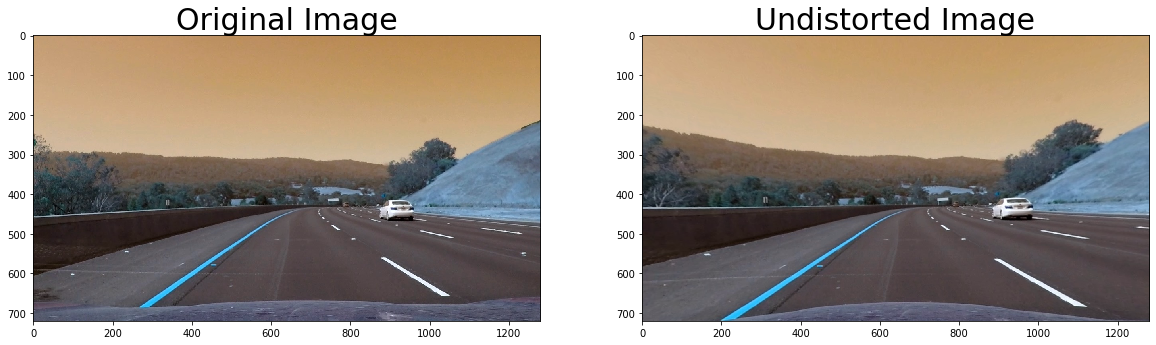

In [43]:
img = cv2.imread('test_images/test3.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline 

In [49]:
image = cv2.imread('test_images/test3.jpg')
src = np.float32([[500, 470],       #top left
                    [800, 470],     #top right
                    [image.shape[1], image.shape[0]],     #bottom right
                    [0, image.shape[0]]])    #bottom left

dst = np.float32([[100, 0],
                    [1200, 0],
                    [1200, image.shape[0]],
                    [100, image.shape[0]]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

In [58]:
from hls_color_threshold import *
from sobel_abs import abs_sobel_thresh
from sobel_dir import dir_threshold
from sobel_mag import mag_thresh

def process(img, M_inv=M_inv, obj_points=mtx, img_points=dist, ksize=5, nwindows=40, margin=40, minpix=40):
    # Step 1. Undistort image
    und_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Step 2. Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls = hls_select(und_img, thresh=(90, 256))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |  (hls == 1)] = 1
    
    # Step 3. Perform a perspective transform
    
    warped = cv2.warpPerspective(combined, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    # Step 4. Find lane line pixels in a binary warped image and fit 2nd order polynomial
    # Step 5. Find radius of curvature and offset of vehicle from lane centerline
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    left_curverad = curv_obj['left_curverad']
    right_curverad = curv_obj['right_curverad']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    
    # Step 6. Overlay identified lane on original image
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
    lane_img = map_curv(lane_img, curvature, offset)
    
    return {'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
            'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
            'right_lane_inds':right_lane_inds, 'left_curverad':left_curverad,\
            'right_curverad':right_curverad, 'warped':warped, 'ploty':ploty, 'M_inv':M_inv, 'und_img':und_img}

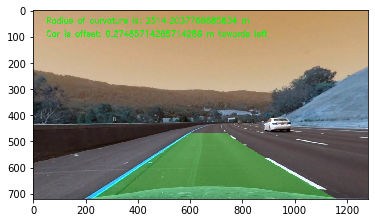

In [59]:
plt.imshow(process(image)['lane_img'])
plt.show()

In [60]:
class MyVideoProcessor(object):

    # constructor function
    def __init__(self):
        # frame count
        self.count = 0
        # values of the last 10 fits of the line
        self.past_frames_left = collections.deque(maxlen=10)
        self.past_frames_right = collections.deque(maxlen=10)

        # values of fits of the line for previous frame
        self.last_fit_left = []
        self.last_fit_right = []

        # curvature for previous frame
        self.left_curverad = []
        self.right_curverad = []
        self.curvature = []
        
        # offset for previous frame
        self.offset = []
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None 
        self.best_fit_right = None 

    def pipeline_function(self, frame):
        # your lane detection pipeline
        if self.count < 10:
            pipeline = process(frame)
            self.past_frames_left.append(pipeline['left_fit'])
            self.past_frames_right.append(pipeline['right_fit'])
            if self.count == 9:
                self.last_fit_left = pipeline['left_fit']
                self.last_fit_right = pipeline['right_fit']
                self.left_curverad = pipeline['left_curverad']
                self.right_curverad = pipeline['right_curverad']
                self.curvature = pipeline['curvature']
                self.offset = pipeline['offset']
                self.best_fit_left = np.mean(self.past_frames_left, axis = 0)
                self.best_fit_right = np.mean(self.past_frames_right, axis = 0)
            self.count += 1
            return pipeline['lane_img']
        
        else:
            # retrieve stored vals from previous frame
            previous_left_fit = self.last_fit_left
            previous_right_fit = self.last_fit_right
            previous_left_curv = self.left_curverad
            previous_right_curv = self.right_curverad
            previous_curvature = self.curvature
            previous_offset = self.offset
            avg_left_fit = self.best_fit_left
            avg_right_fit = self.best_fit_right
            y_delx = frame.shape[0] - 1
            prev_delx = abs(avg_left_fit[0]*y_delx**2 + avg_left_fit[1]*y_delx + avg_left_fit[2] \
            - avg_right_fit[0]*y_delx**2 + avg_right_fit[1]*y_delx + avg_right_fit[2])
            
            # process and evaluate vals for current frame
            pipeline = process(frame)
            und_img = pipeline['und_img']
            current_left_fit = pipeline['left_fit']
            current_right_fit = pipeline['right_fit']
            current_left_curv = pipeline['left_curverad']
            current_right_curv = pipeline['right_curverad']
            current_curvature = pipeline['curvature']
            current_offset = pipeline['offset']
            current_delx = abs(current_left_fit[0]*y_delx**2 + current_left_fit[1]*y_delx + current_left_fit[2] \
            - current_right_fit[0]*y_delx**2 + current_right_fit[1]*y_delx + current_right_fit[2])         
#             print(current_delx)
#             print(abs(current_curvature))
#             print(current_left_fit.shape[0])
#             print(current_right_fit.shape[0])
            
            # perform sanity checks
            if (current_left_fit.shape[0] == 0) | (current_right_fit.shape[0] == 0) | \
             (abs(current_curvature) > 10000) | (abs(current_curvature) < 800) | (current_delx > 1550) | (current_delx < 1100):
                current_left_fit = avg_left_fit
                current_right_fit = avg_right_fit
                current_curvature = previous_curvature
                current_offset = previous_offset
                
            self.past_frames_left.append(current_left_fit)
            self.past_frames_right.append(current_right_fit)
            current_avg_left_fit = np.mean(self.past_frames_left, axis = 0)
            current_avg_right_fit = np.mean(self.past_frames_right, axis = 0) 
            self.best_fit_left = current_avg_left_fit 
            self.best_fit_right = current_avg_right_fit
            self.curvature = current_curvature
            self.offset = current_offset
            
            M_inv = pipeline['M_inv']
            warped = pipeline['warped']
            ploty = pipeline['ploty']
            left_fitx = current_avg_left_fit[0]*ploty**2 + current_avg_left_fit[1]*ploty + current_avg_left_fit[2]
            right_fitx = current_avg_right_fit[0]*ploty**2 + current_avg_right_fit[1]*ploty + current_avg_right_fit[2]
            lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
            lane_img = map_curv(lane_img, current_curvature, current_offset)
            self.count += 1
            return lane_img

In [61]:
# # load project video
# project_video = 'project_video.mp4'
# clip1 = VideoFileClip(project_video).subclip(0,5)
# white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!

my_video_processor_object = MyVideoProcessor()
output = 'test_videos_output/project_video.mp4'
clip = VideoFileClip("test_videos/project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline_function)

%time white_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

                                                               
                                                            


                                                     

t:  49%|████▉     | 617/1260 [05:15<00:38, 16.69it/s, now=None]


t:   6%|▌         | 71/1260 [01:57<01:05, 18.18it/s, now=None]

                                                               
                                                            


                                                     

t:  49%|████▉     | 617/1260 [05:15<00:38, 16.69it/s, now=None]


t:   6%|▌         | 71/1260 [01:57<01:05, 18.18it/s, now=None]

t:  13%|█▎        | 159/1260 [02:50<01:03, 17.42it/s, now=None]



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4







t:   0%|          | 2/1260 [00:00<01:55, 10.87it/s, now=None]



t:   0%|          | 3/1260 [00:00<02:27,  8.51it/s, now=None]



t:   0%|          | 4/1260 [00:00<02:48,  7.44it/s, now=None]



t:   0%|          | 5/1260 [00:00<03:04,  6.82it/s, now=None]



t:   0%|          | 6/1260 [00:00<03:12,  6.50it/s, now=None]



t:   1%|          | 7/1260 [00:01<03:20,  6.26it/s, now=None]



t:   1%|          | 8/1260 [00:01<03:25,  6.09it/s, now=None]



t:   1%|          | 9/1260 [00:01<03:27,  6.02it/s, now=None]



t:   1%|          | 10/1260 [00:01<03:28,  6.00it/s, now=None]



t:   1%|          | 11/1260 [00:01<03:30,  5.92it/s, now=None]



t:   1%|          | 12/1260 [00:01<03:38,  5.72it/s, now=None]



t:   1%|          | 13/1260 [00:02<03:44,  5.54it/s, now=None]



t:   1%|          | 14/1260 [00:02<03:50,  5.41it/s, now=None]



t:   1%|          | 15/1260 [00:02<03:54,  5.30it/s, now=None]



t:   1%|▏         | 16/1260 [00:02<03:57,  5.25it/s, now=None]



t:   1%|▏     

t:   8%|▊         | 107/1260 [00:20<03:42,  5.18it/s, now=None]



t:   9%|▊         | 108/1260 [00:20<03:43,  5.15it/s, now=None]



t:   9%|▊         | 109/1260 [00:20<03:43,  5.14it/s, now=None]



t:   9%|▊         | 110/1260 [00:20<03:43,  5.15it/s, now=None]



t:   9%|▉         | 111/1260 [00:21<03:43,  5.15it/s, now=None]



t:   9%|▉         | 112/1260 [00:21<03:41,  5.19it/s, now=None]



t:   9%|▉         | 113/1260 [00:21<03:40,  5.21it/s, now=None]



t:   9%|▉         | 114/1260 [00:21<03:40,  5.20it/s, now=None]



t:   9%|▉         | 115/1260 [00:21<03:40,  5.19it/s, now=None]



t:   9%|▉         | 116/1260 [00:21<03:39,  5.21it/s, now=None]



t:   9%|▉         | 117/1260 [00:22<03:40,  5.18it/s, now=None]



t:   9%|▉         | 118/1260 [00:22<03:43,  5.11it/s, now=None]



t:   9%|▉         | 119/1260 [00:22<03:44,  5.08it/s, now=None]



t:  10%|▉         | 120/1260 [00:22<03:44,  5.08it/s, now=None]



t:  10%|▉         | 121/1260 [00:22<03:41,  5.14it/s, now=None

t:  17%|█▋        | 210/1260 [00:40<03:24,  5.14it/s, now=None]



t:  17%|█▋        | 211/1260 [00:40<03:27,  5.07it/s, now=None]



t:  17%|█▋        | 212/1260 [00:40<03:26,  5.06it/s, now=None]



t:  17%|█▋        | 213/1260 [00:40<03:26,  5.07it/s, now=None]



t:  17%|█▋        | 214/1260 [00:41<03:24,  5.12it/s, now=None]



t:  17%|█▋        | 215/1260 [00:41<03:23,  5.14it/s, now=None]



t:  17%|█▋        | 216/1260 [00:41<03:22,  5.15it/s, now=None]



t:  17%|█▋        | 217/1260 [00:41<03:23,  5.11it/s, now=None]



t:  17%|█▋        | 218/1260 [00:41<03:23,  5.11it/s, now=None]



t:  17%|█▋        | 219/1260 [00:42<03:24,  5.10it/s, now=None]



t:  17%|█▋        | 220/1260 [00:42<03:23,  5.12it/s, now=None]



t:  18%|█▊        | 221/1260 [00:42<03:24,  5.08it/s, now=None]



t:  18%|█▊        | 222/1260 [00:42<03:24,  5.07it/s, now=None]



t:  18%|█▊        | 223/1260 [00:42<03:24,  5.08it/s, now=None]



t:  18%|█▊        | 224/1260 [00:42<03:23,  5.08it/s, now=None

t:  25%|██▍       | 313/1260 [01:00<03:10,  4.96it/s, now=None]



t:  25%|██▍       | 314/1260 [01:00<03:12,  4.90it/s, now=None]



t:  25%|██▌       | 315/1260 [01:00<03:09,  4.98it/s, now=None]



t:  25%|██▌       | 316/1260 [01:00<03:05,  5.08it/s, now=None]



t:  25%|██▌       | 317/1260 [01:01<03:04,  5.12it/s, now=None]



t:  25%|██▌       | 318/1260 [01:01<03:03,  5.13it/s, now=None]



t:  25%|██▌       | 319/1260 [01:01<03:04,  5.09it/s, now=None]



t:  25%|██▌       | 320/1260 [01:01<03:05,  5.08it/s, now=None]



t:  25%|██▌       | 321/1260 [01:01<03:05,  5.06it/s, now=None]



t:  26%|██▌       | 322/1260 [01:02<03:03,  5.11it/s, now=None]



t:  26%|██▌       | 323/1260 [01:02<03:02,  5.13it/s, now=None]



t:  26%|██▌       | 324/1260 [01:02<03:02,  5.13it/s, now=None]



t:  26%|██▌       | 325/1260 [01:02<03:00,  5.18it/s, now=None]



t:  26%|██▌       | 326/1260 [01:02<03:01,  5.15it/s, now=None]



t:  26%|██▌       | 327/1260 [01:03<03:02,  5.13it/s, now=None

t:  33%|███▎      | 416/1260 [01:20<02:39,  5.29it/s, now=None]



t:  33%|███▎      | 417/1260 [01:20<02:40,  5.26it/s, now=None]



t:  33%|███▎      | 418/1260 [01:20<02:40,  5.25it/s, now=None]



t:  33%|███▎      | 419/1260 [01:20<02:39,  5.27it/s, now=None]



t:  33%|███▎      | 420/1260 [01:20<02:39,  5.26it/s, now=None]



t:  33%|███▎      | 421/1260 [01:20<02:38,  5.28it/s, now=None]



t:  33%|███▎      | 422/1260 [01:21<02:39,  5.26it/s, now=None]



t:  34%|███▎      | 423/1260 [01:21<02:39,  5.24it/s, now=None]



t:  34%|███▎      | 424/1260 [01:21<02:39,  5.25it/s, now=None]



t:  34%|███▎      | 425/1260 [01:21<02:38,  5.26it/s, now=None]



t:  34%|███▍      | 426/1260 [01:21<02:38,  5.25it/s, now=None]



t:  34%|███▍      | 427/1260 [01:22<02:37,  5.28it/s, now=None]



t:  34%|███▍      | 428/1260 [01:22<02:38,  5.26it/s, now=None]



t:  34%|███▍      | 429/1260 [01:22<02:38,  5.25it/s, now=None]



t:  34%|███▍      | 430/1260 [01:22<02:38,  5.25it/s, now=None

t:  41%|████      | 519/1260 [01:39<02:23,  5.17it/s, now=None]



t:  41%|████▏     | 520/1260 [01:40<02:22,  5.21it/s, now=None]



t:  41%|████▏     | 521/1260 [01:40<02:21,  5.22it/s, now=None]



t:  41%|████▏     | 522/1260 [01:40<02:21,  5.20it/s, now=None]



t:  42%|████▏     | 523/1260 [01:40<02:20,  5.23it/s, now=None]



t:  42%|████▏     | 524/1260 [01:40<02:20,  5.25it/s, now=None]



t:  42%|████▏     | 525/1260 [01:41<02:19,  5.26it/s, now=None]



t:  42%|████▏     | 526/1260 [01:41<02:19,  5.25it/s, now=None]



t:  42%|████▏     | 527/1260 [01:41<02:20,  5.23it/s, now=None]



t:  42%|████▏     | 528/1260 [01:41<02:21,  5.17it/s, now=None]



t:  42%|████▏     | 529/1260 [01:41<02:21,  5.18it/s, now=None]



t:  42%|████▏     | 530/1260 [01:42<02:20,  5.18it/s, now=None]



t:  42%|████▏     | 531/1260 [01:42<02:19,  5.21it/s, now=None]



t:  42%|████▏     | 532/1260 [01:42<02:19,  5.23it/s, now=None]



t:  42%|████▏     | 533/1260 [01:42<02:19,  5.23it/s, now=None

t:  49%|████▉     | 622/1260 [01:59<02:00,  5.27it/s, now=None]



t:  49%|████▉     | 623/1260 [01:59<02:00,  5.27it/s, now=None]



t:  50%|████▉     | 624/1260 [01:59<02:01,  5.26it/s, now=None]



t:  50%|████▉     | 625/1260 [02:00<01:59,  5.29it/s, now=None]



t:  50%|████▉     | 626/1260 [02:00<01:59,  5.30it/s, now=None]



t:  50%|████▉     | 627/1260 [02:00<01:59,  5.28it/s, now=None]



t:  50%|████▉     | 628/1260 [02:00<01:59,  5.28it/s, now=None]



t:  50%|████▉     | 629/1260 [02:00<02:00,  5.25it/s, now=None]



t:  50%|█████     | 630/1260 [02:01<01:59,  5.26it/s, now=None]



t:  50%|█████     | 631/1260 [02:01<01:58,  5.29it/s, now=None]



t:  50%|█████     | 632/1260 [02:01<01:59,  5.27it/s, now=None]



t:  50%|█████     | 633/1260 [02:01<01:58,  5.29it/s, now=None]



t:  50%|█████     | 634/1260 [02:01<01:58,  5.30it/s, now=None]



t:  50%|█████     | 635/1260 [02:02<01:58,  5.29it/s, now=None]



t:  50%|█████     | 636/1260 [02:02<01:57,  5.30it/s, now=None

t:  58%|█████▊    | 725/1260 [02:20<01:44,  5.14it/s, now=None]



t:  58%|█████▊    | 726/1260 [02:20<01:42,  5.19it/s, now=None]



t:  58%|█████▊    | 727/1260 [02:20<01:41,  5.23it/s, now=None]



t:  58%|█████▊    | 728/1260 [02:21<01:41,  5.24it/s, now=None]



t:  58%|█████▊    | 729/1260 [02:21<01:40,  5.27it/s, now=None]



t:  58%|█████▊    | 730/1260 [02:21<01:40,  5.29it/s, now=None]



t:  58%|█████▊    | 731/1260 [02:21<01:40,  5.28it/s, now=None]



t:  58%|█████▊    | 732/1260 [02:21<01:41,  5.20it/s, now=None]



t:  58%|█████▊    | 733/1260 [02:22<01:41,  5.18it/s, now=None]



t:  58%|█████▊    | 734/1260 [02:22<01:41,  5.21it/s, now=None]



t:  58%|█████▊    | 735/1260 [02:22<01:42,  5.10it/s, now=None]



t:  58%|█████▊    | 736/1260 [02:22<01:42,  5.12it/s, now=None]



t:  58%|█████▊    | 737/1260 [02:22<01:41,  5.16it/s, now=None]



t:  59%|█████▊    | 738/1260 [02:23<01:40,  5.20it/s, now=None]



t:  59%|█████▊    | 739/1260 [02:23<01:39,  5.25it/s, now=None

t:  66%|██████▌   | 828/1260 [02:40<01:23,  5.19it/s, now=None]



t:  66%|██████▌   | 829/1260 [02:40<01:23,  5.18it/s, now=None]



t:  66%|██████▌   | 830/1260 [02:40<01:23,  5.18it/s, now=None]



t:  66%|██████▌   | 831/1260 [02:40<01:22,  5.18it/s, now=None]



t:  66%|██████▌   | 832/1260 [02:40<01:22,  5.20it/s, now=None]



t:  66%|██████▌   | 833/1260 [02:41<01:21,  5.21it/s, now=None]



t:  66%|██████▌   | 834/1260 [02:41<01:21,  5.22it/s, now=None]



t:  66%|██████▋   | 835/1260 [02:41<01:21,  5.20it/s, now=None]



t:  66%|██████▋   | 836/1260 [02:41<01:21,  5.21it/s, now=None]



t:  66%|██████▋   | 837/1260 [02:41<01:21,  5.20it/s, now=None]



t:  67%|██████▋   | 838/1260 [02:42<01:21,  5.17it/s, now=None]



t:  67%|██████▋   | 839/1260 [02:42<01:21,  5.17it/s, now=None]



t:  67%|██████▋   | 840/1260 [02:42<01:21,  5.17it/s, now=None]



t:  67%|██████▋   | 841/1260 [02:42<01:20,  5.18it/s, now=None]



t:  67%|██████▋   | 842/1260 [02:42<01:20,  5.17it/s, now=None

t:  74%|███████▍  | 931/1260 [03:00<01:04,  5.10it/s, now=None]



t:  74%|███████▍  | 932/1260 [03:00<01:04,  5.10it/s, now=None]



t:  74%|███████▍  | 933/1260 [03:00<01:03,  5.11it/s, now=None]



t:  74%|███████▍  | 934/1260 [03:00<01:03,  5.12it/s, now=None]



t:  74%|███████▍  | 935/1260 [03:01<01:03,  5.12it/s, now=None]



t:  74%|███████▍  | 936/1260 [03:01<01:03,  5.13it/s, now=None]



t:  74%|███████▍  | 937/1260 [03:01<01:02,  5.16it/s, now=None]



t:  74%|███████▍  | 938/1260 [03:01<01:02,  5.17it/s, now=None]



t:  75%|███████▍  | 939/1260 [03:01<01:02,  5.15it/s, now=None]



t:  75%|███████▍  | 940/1260 [03:02<01:02,  5.12it/s, now=None]



t:  75%|███████▍  | 941/1260 [03:02<01:02,  5.13it/s, now=None]



t:  75%|███████▍  | 942/1260 [03:02<01:01,  5.15it/s, now=None]



t:  75%|███████▍  | 943/1260 [03:02<01:01,  5.16it/s, now=None]



t:  75%|███████▍  | 944/1260 [03:02<01:01,  5.16it/s, now=None]



t:  75%|███████▌  | 945/1260 [03:03<01:00,  5.18it/s, now=None

t:  82%|████████▏ | 1034/1260 [03:20<00:45,  4.96it/s, now=None]



t:  82%|████████▏ | 1035/1260 [03:20<00:46,  4.88it/s, now=None]



t:  82%|████████▏ | 1036/1260 [03:20<00:47,  4.75it/s, now=None]



t:  82%|████████▏ | 1037/1260 [03:21<00:47,  4.67it/s, now=None]



t:  82%|████████▏ | 1038/1260 [03:21<00:47,  4.63it/s, now=None]



t:  82%|████████▏ | 1039/1260 [03:21<00:48,  4.57it/s, now=None]



t:  83%|████████▎ | 1040/1260 [03:21<00:48,  4.53it/s, now=None]



t:  83%|████████▎ | 1041/1260 [03:21<00:48,  4.50it/s, now=None]



t:  83%|████████▎ | 1042/1260 [03:22<00:48,  4.46it/s, now=None]



t:  83%|████████▎ | 1043/1260 [03:22<00:49,  4.42it/s, now=None]



t:  83%|████████▎ | 1044/1260 [03:22<00:48,  4.41it/s, now=None]



t:  83%|████████▎ | 1045/1260 [03:22<00:49,  4.38it/s, now=None]



t:  83%|████████▎ | 1046/1260 [03:23<00:50,  4.24it/s, now=None]



t:  83%|████████▎ | 1047/1260 [03:23<00:51,  4.11it/s, now=None]



t:  83%|████████▎ | 1048/1260 [03:23<00:52,  4.0

t:  90%|█████████ | 1136/1260 [03:43<00:26,  4.72it/s, now=None]



t:  90%|█████████ | 1137/1260 [03:43<00:25,  4.77it/s, now=None]



t:  90%|█████████ | 1138/1260 [03:43<00:25,  4.80it/s, now=None]



t:  90%|█████████ | 1139/1260 [03:44<00:25,  4.81it/s, now=None]



t:  90%|█████████ | 1140/1260 [03:44<00:24,  4.86it/s, now=None]



t:  91%|█████████ | 1141/1260 [03:44<00:24,  4.87it/s, now=None]



t:  91%|█████████ | 1142/1260 [03:44<00:25,  4.67it/s, now=None]



t:  91%|█████████ | 1143/1260 [03:44<00:24,  4.71it/s, now=None]



t:  91%|█████████ | 1144/1260 [03:45<00:24,  4.75it/s, now=None]



t:  91%|█████████ | 1145/1260 [03:45<00:23,  4.80it/s, now=None]



t:  91%|█████████ | 1146/1260 [03:45<00:23,  4.82it/s, now=None]



t:  91%|█████████ | 1147/1260 [03:45<00:23,  4.86it/s, now=None]



t:  91%|█████████ | 1148/1260 [03:46<00:22,  4.90it/s, now=None]



t:  91%|█████████ | 1149/1260 [03:46<00:22,  4.89it/s, now=None]



t:  91%|█████████▏| 1150/1260 [03:46<00:22,  4.8

t:  98%|█████████▊| 1238/1260 [04:05<00:05,  4.05it/s, now=None]



t:  98%|█████████▊| 1239/1260 [04:05<00:05,  4.01it/s, now=None]



t:  98%|█████████▊| 1240/1260 [04:06<00:04,  4.04it/s, now=None]



t:  98%|█████████▊| 1241/1260 [04:06<00:04,  4.12it/s, now=None]



t:  99%|█████████▊| 1242/1260 [04:06<00:04,  4.16it/s, now=None]



t:  99%|█████████▊| 1243/1260 [04:06<00:04,  3.93it/s, now=None]



t:  99%|█████████▊| 1244/1260 [04:07<00:04,  3.99it/s, now=None]



t:  99%|█████████▉| 1245/1260 [04:07<00:03,  4.05it/s, now=None]



t:  99%|█████████▉| 1246/1260 [04:07<00:03,  4.09it/s, now=None]



t:  99%|█████████▉| 1247/1260 [04:07<00:03,  4.12it/s, now=None]



t:  99%|█████████▉| 1248/1260 [04:08<00:02,  4.12it/s, now=None]



t:  99%|█████████▉| 1249/1260 [04:08<00:02,  3.94it/s, now=None]



t:  99%|█████████▉| 1250/1260 [04:08<00:02,  4.00it/s, now=None]



t:  99%|█████████▉| 1251/1260 [04:08<00:02,  3.98it/s, now=None]



t:  99%|█████████▉| 1252/1260 [04:09<00:01,  4.0

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 4min 18s, sys: 1min 1s, total: 5min 20s
Wall time: 4min 12s
